In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

np.random.seed(2)
from skimage import io

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.applications.imagenet_utils import preprocess_input


sns.set(style='white', context='notebook', palette='deep')

C:\Users\RAMBABU\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# Load the data
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

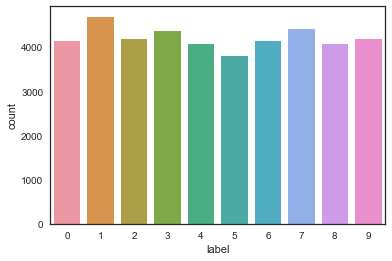

In [4]:
Y_train = train["label"]

# Drop 'label' column
X_train = train.drop(labels = ["label"],axis = 1) 

# free some space
#del train 

g = sns.countplot(Y_train)

Y_train.value_counts()

In [5]:
# Check the data
X_train.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [6]:
test.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [7]:
# Normalize the data
X_train = X_train / 255.0
test = test / 255.0

In [8]:
# Reshape image in 3 dimensions (height = 28px, width = 28px , canal = 1)
X_train = X_train.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)

In [9]:
# Encode labels to one hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
Y_train = to_categorical(Y_train, num_classes = 10)

In [10]:
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.1)

In [11]:
# Set the CNN model 
# my CNN architechture is In -> [[Conv2D->relu]*2 -> MaxPool2D -> Dropout]*2 -> Flatten -> Dense -> Dropout -> Out

model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))

#model.add(Conv2D(filters = 256, kernel_size = (7, 7), padding = 'valid',
#                activation = 'relu'))
#model.add(Dropout(0.5))
#model.add(Conv2D(filters = 10, kernel_size = (1, 1), padding = 'Same',
#                 activation = 'softmax'))
#model.add(Flatten())

In [12]:
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

In [13]:
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [14]:
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [15]:
epochs = 30 # Turn epochs to 30 to get 0.9967 accuracy
batch_size = 86

In [16]:
# With data augmentation to prevent overfitting (accuracy 0.99286)

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(X_train)

In [17]:
history = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])

Epoch 1/30
 - 54s - loss: 0.4184 - acc: 0.8664 - val_loss: 0.0621 - val_acc: 0.9807
Epoch 2/30
 - 43s - loss: 0.1305 - acc: 0.9610 - val_loss: 0.0501 - val_acc: 0.9838
Epoch 3/30
 - 42s - loss: 0.0933 - acc: 0.9725 - val_loss: 0.0370 - val_acc: 0.9898
Epoch 4/30
 - 42s - loss: 0.0798 - acc: 0.9758 - val_loss: 0.0319 - val_acc: 0.9912
Epoch 5/30
 - 42s - loss: 0.0727 - acc: 0.9782 - val_loss: 0.0270 - val_acc: 0.9917
Epoch 6/30
 - 43s - loss: 0.0672 - acc: 0.9807 - val_loss: 0.0316 - val_acc: 0.9921
Epoch 7/30
 - 42s - loss: 0.0636 - acc: 0.9814 - val_loss: 0.0244 - val_acc: 0.9929
Epoch 8/30
 - 42s - loss: 0.0621 - acc: 0.9814 - val_loss: 0.0244 - val_acc: 0.9924
Epoch 9/30
 - 42s - loss: 0.0619 - acc: 0.9830 - val_loss: 0.0245 - val_acc: 0.9931
Epoch 10/30
 - 42s - loss: 0.0601 - acc: 0.9823 - val_loss: 0.0270 - val_acc: 0.9924
Epoch 11/30
 - 42s - loss: 0.0609 - acc: 0.9833 - val_loss: 0.0268 - val_acc: 0.9907
Epoch 12/30
 - 42s - loss: 0.0612 - acc: 0.9832 - val_loss: 0.0260 - val_a

In [18]:
model.save('model.h5')